### Import and install the lib

In [90]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import re
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [91]:
try:
    print("Installing geopy and geocoder...\n")
    #!conda install -c conda-forge geopy --yes
    !pip install geocoder
    !pip install geopy
    print("geocoder and geopy has been successfully installed!\n")
except:
    print("ERROR: could not install geopy!\n")
    
try:
    print("Installing folium...\n")
    #!conda install -c conda-forge folium --yes
    !pip install folium
    print("folium has been successfully installed!\n")
except:
    print("ERROR: could not install folium!\n")

import folium # map rendering library


import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Libraries imported.')

Installing geopy and geocoder...

geocoder and geopy has been successfully installed!

Installing folium...

folium has been successfully installed!

Libraries imported.


### Scrape the wiki page to get postcode data

In [92]:
#url = 'https://www.squarefoot.com.hk/transactions/'
#url = 'https://en.wikipedia.org/wiki/Districts_of_Hong_Kong'
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url)

soup = BeautifulSoup(html,'html.parser')

soup_1 = soup.find_all('table')
table = soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="Popular Estates") 

tables = soup.find('table')

In [93]:
#Create array to hold the data we extract
data_postal_code = []
data_borough = []
data_neighbour = []

rows = tables.find_all('tr')
print('there are %d rows'%(len(rows)))
for row in rows:
    cells = row.find_all('td')

    #print('there are %d cells'%(len(cells)))
    if len(cells) > 1:
        postal_code = cells[0]
        data_postal_code.append(postal_code.text.strip())

        borough = cells[1]
        data_borough.append(borough.text.strip())

        neighbour = cells[2]
        #print(neighbour.text)
        data_neighbour.append(neighbour.text.strip())
        
    #data_neighbour

there are 181 rows


### Convert the data into dataframe

In [94]:
df = pd.DataFrame(data_postal_code, columns = ['PostalCode'])
df['Borough'] = data_borough
df['Neighbourhood'] = data_neighbour
num = df.shape
print('origial df has %d rows'%(num[0]))
#df.drop(df['Borough'] == 'Not assigned', inplace = True)
df = df[~df['Borough'].str.contains("Not assigned")]
df.groupby(['PostalCode','Borough'])['Neighbourhood'].agg(','.join).reset_index()
df.head(20)

origial df has 180 rows


,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


### Find the lat and long of Toronto

In [95]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.6534817, -79.3839347.


### Import the data lat and long of Toronto disctrict

In [96]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ac391cda40084063a272c3b262c6a5d2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='mN6E_HbuMKBWLJwiy-CNSvIC5VwrkHGegk4uo-xHAUD5',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ac391cda40084063a272c3b262c6a5d2.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-gamtkiidehvnk2',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_lat_long = pd.read_csv(body)
df_lat_long.rename(columns = {'Postal Code':'PostalCode'},inplace = True)
df_lat_long.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge the dataframe

In [97]:
df_geo = pd.merge(df, df_lat_long, on = 'PostalCode')
df_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [98]:
# set number of clusters
kclusters = 3

X = df_geo['Latitude']
Y = df_geo['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Z)

clusters = kmeans.labels_
colors_list = ['red', 'green', 'blue', 'yellow','black']
df_geo['Cluster'] = clusters

#df_geo['Cluster']

In [99]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, cluster in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Borough'], df_geo['Cluster']):
    label = '{}, {}'.format(cluster, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=colors_list[cluster-1],
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Fursquare data

In [100]:
CLIENT_ID = 'UUYBANZY0AJYA2OBFI1OHUHLZZLN5RRJMKZWTBLTQAEMUYCN' # your Foursquare ID
CLIENT_SECRET = '1NFDI3XCY3MCXY5V3YW1ULMNG0RCZMCDXZL32L4FA2J2NV3S' # your Foursquare Secret
VERSION = '20200904'
LIMIT = 40
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UUYBANZY0AJYA2OBFI1OHUHLZZLN5RRJMKZWTBLTQAEMUYCN
CLIENT_SECRET:1NFDI3XCY3MCXY5V3YW1ULMNG0RCZMCDXZL32L4FA2J2NV3S


In [101]:
request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": '20200904',
    #"ll": [latitude,longitude],
    "near": "Toronto",
    "radius": 1000,
    "limit": 100}

data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters)

In [102]:
results = data.json()
d = data.json()["response"]
d.keys()

dict_keys(['suggestedFilters', 'geocode', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'totalResults', 'suggestedBounds', 'groups'])

In [103]:
d["headerLocationGranularity"], d["headerLocation"], d["headerFullLocation"]
d["suggestedBounds"], d["totalResults"]

({'ne': {'lat': 43.70527240345191, 'lng': -79.40493504508552},
  'sw': {'lat': 43.69759580819633, 'lng': -79.42984773499137}},
 42)

In [104]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [105]:

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Abbot,Gastropub,43.703688,-79.413485
1,Hotel Gelato,Café,43.703478,-79.414311
2,The Mad Bean Coffee House,Coffee Shop,43.703529,-79.413698
3,7 Numbers,Italian Restaurant,43.703630,-79.413724
4,Tokyo Sushi,Sushi Restaurant,43.704146,-79.410631


In [106]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
print ('{} unique categories in Toronto'.format(nearby_venues['categories'].value_counts().shape[0]))
print (nearby_venues['categories'].value_counts()[0:10])

42 venues were returned by Foursquare.
31 unique categories in Toronto
Coffee Shop            4
Italian Restaurant     3
Bank                   2
Trail                  2
Japanese Restaurant    2
Bagel Shop             2
Sushi Restaurant       2
Pizza Place            2
Garden                 1
Deli / Bodega          1
Name: categories, dtype: int64


### Explore Neighbourhood in Toronto

In [107]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [108]:
Toronto_venues = getNearbyVenues(names=df_geo['Neighbourhood'],latitudes=df_geo['Latitude'],longitudes=df_geo['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [109]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Toronto_Venues_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Toronto_Venues_restaurant.index = np.arange(1, len(Toronto_Venues_restaurant )+1)

print (Toronto_Venues_restaurant['Venue Category'].value_counts())
print('There are {} uniques categories.'.format(len(Toronto_Venues_restaurant['Venue Category'].unique())))

Restaurant                       51
Italian Restaurant               27
Japanese Restaurant              24
Sushi Restaurant                 20
Fast Food Restaurant             18
American Restaurant              16
Mexican Restaurant               15
Thai Restaurant                  15
Seafood Restaurant               13
Chinese Restaurant               13
Greek Restaurant                 11
Indian Restaurant                11
Vegetarian / Vegan Restaurant    10
Middle Eastern Restaurant        10
Vietnamese Restaurant             9
French Restaurant                 7
Ramen Restaurant                  7
Asian Restaurant                  7
Comfort Food Restaurant           6
Caribbean Restaurant              6
New American Restaurant           6
Latin American Restaurant         4
Mediterranean Restaurant          3
Portuguese Restaurant             3
Korean Restaurant                 2
Gluten-free Restaurant            2
Cuban Restaurant                  2
Modern European Restaurant  

In [110]:
# create a dataframe of top 10 categories
Toronto_restaurant_Top10 = Toronto_Venues_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Toronto_restaurant_Top10 = Toronto_restaurant_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Toronto_restaurant_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Toronto_restaurant_Top10

,Venue_Category,Frequency
0,Restaurant,51
1,Italian Restaurant,27
2,Japanese Restaurant,24
3,Sushi Restaurant,20
4,Fast Food Restaurant,18
5,American Restaurant,16
6,Mexican Restaurant,15
7,Thai Restaurant,15
8,Seafood Restaurant,13
9,Chinese Restaurant,13


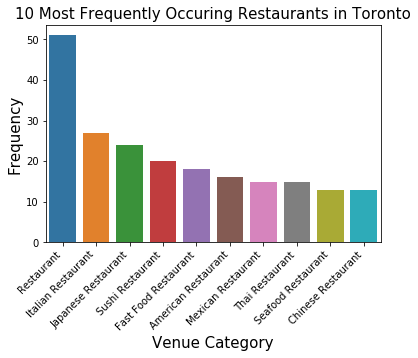

<Figure size 1296x504 with 0 Axes>

In [111]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Toronto_restaurant_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Restaurants in Toronto', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
#plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [112]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Toronto_Venues_restaurant.shape)
Toronto_Venues_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (334, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
5,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Lac Vien Vietnamese Restaurant,43.721259,-79.468472,Vietnamese Restaurant
6,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Nando's,43.661728,-79.386391,Portuguese Restaurant
7,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
8,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Tokyo Sushi,43.665885,-79.386977,Sushi Restaurant
9,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Como En Casa,43.665160,-79.384796,Mexican Restaurant
10,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Crown Princess Fine Dining 伯爵名宴,43.666455,-79.387698,Chinese Restaurant


### Analyze each neiborghhood in Toronto

In [113]:
Toronto_neibor_restaurant = Toronto_Venues_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Toronto_neibor_restaurant

Neighborhood
Agincourt                                                                                                         1
Bathurst Manor, Wilson Heights, Downsview North                                                                   4
Bayview Village                                                                                                   2
Bedford Park, Lawrence Manor East                                                                                 9
Berczy Park                                                                                                      11
Brockton, Parkdale Village, Exhibition Place                                                                      2
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto                              2
Canada Post Gateway Processing Centre                                                                             3
Cedarbrae                                                  

In [114]:
df_toronto_restaurant  = Toronto_neibor_restaurant.to_frame().reset_index()
df_toronto_restaurant.columns = ['Neighborhood', 'Number of Restaurant']
df_toronto_restaurant.index = np.arange(1, len(df_toronto_restaurant)+1)
list_restaurant =df_toronto_restaurant['Number of Restaurant'].to_list()
list_neiborghhood =df_toronto_restaurant['Neighborhood'].to_list()
#print (list_restaurant)
#print (list_neiborghhood)

#### One hot encoding

In [115]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_Venues_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_Venues_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()


,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Lawrence Manor, Lawrence Heights",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [116]:
Toronto_onehot.shape

(334, 43)

#### Group rows by neighborhood and by taking the mean of the frequency

In [117]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Bayview Village,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,"Bedford Park, Lawrence Manor East",0.111111,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,...,0.111111,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.0,0.000000,0.000000
4,Berczy Park,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.090909,0.181818,0.000000,0.090909,0.000000,0.090909,0.000000,0.0,0.090909,0.000000
5,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Canada Post Gateway Processing Centre,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,Cedarbrae,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000
9,Central Bay Street,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.083333,0.000000,0.083333,0.000000,0.083333,0.000000,0.0,0.083333,0.000000


In [118]:
Toronto_grouped.shape

(61, 43)

#### Print the 5 most common venues in each neighborhood

In [119]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   1.0
1        American Restaurant   0.0
2           Ramen Restaurant   0.0
3           Malay Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0         Chinese Restaurant  0.25
1  Middle Eastern Restaurant  0.25
2           Sushi Restaurant  0.25
3                 Restaurant  0.25
4        American Restaurant  0.00


----Bayview Village----
                      venue  freq
0       Japanese Restaurant   0.5
1        Chinese Restaurant   0.5
2                Restaurant   0.0
3          Malay Restaurant   0.0
4  Mediterranean Restaurant   0.0


----Bedford Park, Lawrence Manor East----
                     venue  freq
0       Italian Restaurant  0.22
1      American Restaurant  0.11
2  Comfort Food Restaurant  0.11
3        Indian Restaurant  0.11
4         Greek Restaurant  0.11


----Berczy Park----
          

4  Mediterranean Restaurant   0.0


----Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West----
                      venue  freq
0      Fast Food Restaurant   1.0
1       American Restaurant   0.0
2          Ramen Restaurant   0.0
3          Malay Restaurant   0.0
4  Mediterranean Restaurant   0.0


----New Toronto, Mimico South, Humber Bay Shores----
                  venue  freq
0   American Restaurant  0.25
1  Fast Food Restaurant  0.25
2    Mexican Restaurant  0.25
3            Restaurant  0.25
4      Theme Restaurant  0.00


----North Toronto West,  Lawrence Park----
                  venue  freq
0            Restaurant  0.25
1    Mexican Restaurant  0.25
2    Chinese Restaurant  0.25
3  Fast Food Restaurant  0.25
4      Ramen Restaurant  0.00


----Northwood Park, York University----
                      venue  freq
0      Caribbean Restaurant   1.0
1       American Restaurant   0.0
2                Restaurant   0.0
3          Malay Re

#### Put the frequency data into dataframe

In [120]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Chinese Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Greek Restaurant,Indian Restaurant,Restaurant,American Restaurant,Thai Restaurant,Sri Lankan Restaurant,Gluten-free Restaurant
4,Berczy Park,Seafood Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Greek Restaurant,Restaurant,Comfort Food Restaurant,Sushi Restaurant,Thai Restaurant
5,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
6,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
7,Canada Post Gateway Processing Centre,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
8,Cedarbrae,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
9,Central Bay Street,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Middle Eastern Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Modern European Restaurant,Sushi Restaurant


### Cluster Neighborhoods

In [121]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 0, 1, 1, 1, 2, 1, 1, 1], dtype=int32)

In [122]:
kclusters

5

#### Create a dataframe including the cluster

In [123]:
df_geo.shape

(103, 6)

In [124]:
df_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0


In [125]:
neighborhoods_venues_sorted.shape

(61, 11)

In [126]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Chinese Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Greek Restaurant,Indian Restaurant,Restaurant,American Restaurant,Thai Restaurant,Sri Lankan Restaurant,Gluten-free Restaurant
4,Berczy Park,Seafood Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Greek Restaurant,Restaurant,Comfort Food Restaurant,Sushi Restaurant,Thai Restaurant
5,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
6,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
7,Canada Post Gateway Processing Centre,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
8,Cedarbrae,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
9,Central Bay Street,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Middle Eastern Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Modern European Restaurant,Sushi Restaurant


In [127]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_geo.drop('Cluster',axis=1)

Toronto_merged.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [128]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#Toronto_merged=Toronto_merged.iloc[1:]
Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,Vietnamese Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4.0,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Restaurant,Chinese Restaurant,Portuguese Restaurant,Caribbean Restaurant,Asian Restaurant,Gluten-free Restaurant,French Restaurant


### Visualize the cluster results

In [129]:
Toronto_merged.shape

(103, 16)

In [139]:
Toronto_merged.dropna(axis=0,inplace=True)
Toronto_merged.shape

(62, 16)

In [131]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
map_clusters

In [137]:
rainbow

nan

In [140]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters